# 課程重點:
    
    利用 Keras 建立神經網路模型
    
    查看優化器的結果

# 範例目標:
    
    使用 CIFAR-10 圖庫, 觀察完整神經網路

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [2]:
# Blas GEMM launch failed , 避免動態分配 GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [4]:
# 檢查 Dataset 的描述與資訊
# split data to training and testing sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'training samples')
print(x_test.shape[0], 'testing samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 training samples
10000 testing samples


In [5]:
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

# 第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 輸出結果是 10 個類別，所以維度是 10
model.add(Dense(10))
# 最後一層用 softmax 作為啟動函數
model.add(Activation('softmax'))

In [6]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [7]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [8]:
# 第三步編譯
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [10]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of the dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
         # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True, 
                        verbose=1)

#    第四步：訓練
#    .fit的一些參數
#    batch_size：對總的樣本數進行分組，每組包含的樣本數量
#    epochs ：訓練次數
#    shuffle：是否把數據隨機打亂之後再進行訓練
#    validation_split：拿出百分之多少用來做交叉驗證
#    verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果

Using real-time data augmentation.

Epoch 1/20
1563/1563 [==============================] - 128s 82ms/step - loss: 1.5442 - accuracy: 0.4366 - val_loss: 1.1622 - val_accuracy: 0.5812
Epoch 2/20
1563/1563 [==============================] - 121s 77ms/step - loss: 1.1527 - accuracy: 0.5882 - val_loss: 1.0019 - val_accuracy: 0.6458
Epoch 3/20
1563/1563 [==============================] - 121s 77ms/step - loss: 0.9924 - accuracy: 0.6516 - val_loss: 0.8595 - val_accuracy: 0.6984
Epoch 4/20
1563/1563 [==============================] - 121s 78ms/step - loss: 0.8997 - accuracy: 0.6852 - val_loss: 0.7872 - val_accuracy: 0.7270
Epoch 5/20
1563/1563 [==============================] - 123s 78ms/step - loss: 0.8319 - accuracy: 0.7084 - val_loss: 0.7969 - val_accuracy: 0.7238
Epoch 6/20
1563/1563 [==============================] - 123s 79ms/step - loss: 0.7865 - accuracy: 0.7247 - val_loss: 0.7431 - val_accuracy: 0.7441
Epoch 7/20
1563/1563 [==============================] - 123s 78ms/step - loss: 0.7

In [11]:
# Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# 第六步：輸出
# Score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.6620 - accuracy: 0.7798
Test loss: 0.6619813442230225
Test accuracy: 0.7797999978065491


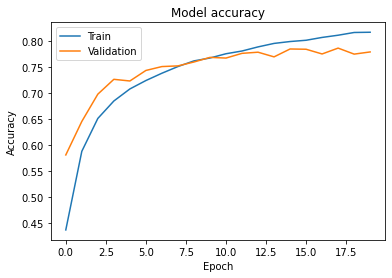

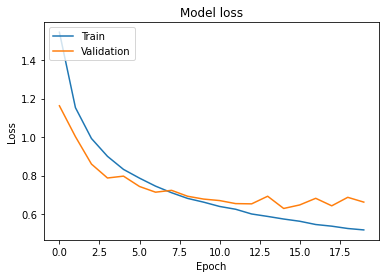

In [12]:
import matplotlib.pyplot as plt

plt.figure()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()